In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from misc import *

from sklearn.decomposition import PCA
import phate


## 1. Import/generate Data

### 1. Load simulated data from Mulistrand

In [75]:
# load text file
f = open('./data/helix_assos/assos_PT3_1sim_20C_21.txt', 'r') # PT3 
STRAND_NAME = "assos_PT3_1sim_20C_21"

# f = open('./data/helix_assos/assos_PT0_1sim_20C_51.txt', 'r') # PT0
# STRAND_NAME = "assos_PT0_1sim_20C_51"

""" Dimenstions of SIM list 
SIM: [[sim1], [sim2], ...]
sim: [[state1], [state2], ...]
state: [structure, time, energy]
"""
# define absorbing (final) state structure
FINAL_STRUCTURE = "(((((((((((((((((((((((((+)))))))))))))))))))))))))"

SIM = loadtrj(f,FINAL_STRUCTURE,type="Multiple")
SIM_retrieve = np.array(SIM)
SIM_concat = concat_helix_structures(SIM) 

print("SIM: ", len(SIM))
print("SIM_retrieve: ", SIM_retrieve.shape)
print("SIM_concat: ", len(SIM_concat))

SIM:  1780
SIM_retrieve:  (1780, 3)
SIM_concat:  1780


### 2. Convert dot-paren to adjacency matrix

In [76]:
""" Dimenstions of SIM_adj list 
SIM_adj: N*m*m
    N: number of states in the trajectory
    m: number of nucleotides in the state (strand)
"""
# get adjacency matrix, energy, and holding time for each state
SIM_adj,SIM_G,SIM_T,SIM_HT = sim_adj(SIM_concat)

In [77]:
SIM_adj.shape,SIM_G.shape,SIM_T.shape,SIM_HT.shape

((1780, 50, 50), (1780,), (1780,), (1780,))

In [78]:
# get unique states adjacency matrix with their occupancy density
# get unique energy, and time;
# and their corresponding indices
indices,occ_density,SIM_adj_uniq,SIM_G_uniq,SIM_T_uniq,SIM_HT_uniq \
     = get_unique(SIM_concat,SIM_adj,SIM_G,SIM_T,SIM_HT)

SIM_adj_uniq.shape,SIM_G_uniq.shape,SIM_T_uniq.shape,SIM_HT_uniq.shape

((812, 50, 50), (812,), (812,), (812,))

### 3. Get labeled trajectory data

In [79]:
# get trajectory data with its corresponding labels 
SIM_dict = label_structures(SIM_concat,indices) 
coord_id = SIM_dict[:,3].astype(int)
SIM_dict.shape, coord_id.shape

((1780, 4), (1780,))

In [80]:
# find the structure having the largest occupancy density
SIM_retrieve[indices[occ_density.argmax()]]

array(['...((..((((....))))(((((.+.)))))..))..(((......))).', '1.506e-06',
       '-10.04'], dtype='<U51')

### 4. Convert adjacency matrix scattering coefficients

In [81]:
# convert all states
scat_coeff_array = transform_dataset(SIM_adj)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar = norm_scat_coeffs
SIM_scar.shape

100%|██████████| 1780/1780 [00:00<00:00, 3469.36it/s]


(1780, 4000)

In [82]:
# convert only unique states to get unique scattering
scat_coeff_array = transform_dataset(SIM_adj_uniq)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar_uniq = norm_scat_coeffs
SIM_scar_uniq.shape

100%|██████████| 812/812 [00:00<00:00, 3436.29it/s]


(812, 4000)

### 5. Split data into tranning and test sets

In [83]:
"""Shape of split data
    train_data: [tr_adjs, tr_coeffs, tr_energies]
    test_data: [te_adjs, te_coeffs, te_energies]
"""
train_data,test_data = split_data(SIM_adj_uniq,SIM_scar_uniq,SIM_G_uniq)

In [84]:
(np.unique(train_data[1],axis=0)).shape, train_data[1].shape,test_data[1].shape

((538, 4000), (568, 4000), (244, 4000))

### 6. Train and test dataloader

In [85]:
"""Structure of train_tup when gnn=False
    train_tup: [train_coeffs,train_energy] 
"""
train_loader, train_tup, test_tup, valid_loader,early_stop_callback = load_trte(train_data,test_data,
                                              batch_size=8)
train_tup[0].shape, test_tup[0].shape, train_loader.batch_size

(torch.Size([568, 4000]), torch.Size([244, 4000]), 8)

## 2.1 Load Model

In [141]:
# set up hyperparameters

input_dim = train_tup[0].shape[-1]
len_epoch = len(train_loader)

hparams = {
    'input_dim':  input_dim,
    'bottle_dim': 25,
    'hidden_dim': 400, #not used in model
    
    'len_epoch': len_epoch,
    'learning_rate': 0.0001,
    'max_epochs': 60,  # PT0 --> 1985 epoch  # PT3 --> 60， 100, 150, 756(overtfit) epoch
    'n_gpus': 0,
    'batch_size': 8, #not used in model
    
    'alpha':1.0,
    'beta':0.0001,

}

In [142]:
hparams = argparse.Namespace(**hparams)

In [143]:
model = GSAE(hparams)

In [144]:
print(model)

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)


## 2.2 Train Model

In [145]:
trainer = pl.Trainer.from_argparse_args(hparams,
                                        max_epochs=hparams.max_epochs,
                                        gpus=hparams.n_gpus,
                                        # callbacks=[early_stop_callback],
                                        )
trainer.fit(model=model,
            train_dataloader=train_loader,
            val_dataloaders=valid_loader,)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | fc11   | Linear      | 1 M   
1 | bn11   | BatchNorm1d | 800   
2 | fc12   | Linear      | 160 K 
3 | bn12   | BatchNorm1d | 800   
4 | fc21   | Linear      | 10 K  
5 | fc22   | Linear      | 10 K  
6 | fc3    | Linear      | 10 K  
7 | fc4    | Linear      | 1 M   
8 | regfc1 | Linear      | 520   
9 | regfc2 | Linear      | 21    


Epoch 0:  16%|█▋        | 14/86 [00:00<00:00, 76.74it/s, loss=68.744, v_num=11]

/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch

Epoch 59: 100%|██████████| 86/86 [00:00<00:00, 91.58it/s, loss=4.012, v_num=11]


1

In [146]:
model

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/ --host localhost --port 8088
#  http://localhost:8088

In [147]:
# save the trained model
# from data I1_10000sim.txt SIM[1]
fname_model = "models/{}_model_{}epoch.pickle".format(STRAND_NAME,hparams.max_epochs)
pickle.dump(model, open(fname_model, 'wb'))
print('Trained model saved.')

Trained model saved.


In [148]:
fname_model

'models/assos_PT3_1sim_20C_21_model_60epoch.pickle'

## 3. Load Pretrained Models

In [149]:
fname_model = "models/assos_PT3_1sim_20C_21_model_60epoch.pickle"
# fname_model = "models/assos_PT0_1sim_20C_51_model_1985epoch.pickle"

model = pickle.load(open(fname_model, 'rb'))
model

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

## 4. Get Embeddings

In [150]:
# without duplicates
with torch.no_grad():
        data_embed = model.embed(torch.Tensor(SIM_scar_uniq))[0]

In [151]:
# do PCA for GSAE embeded data
pca_coords = PCA(n_components=3).fit_transform(data_embed)

# get all pca embedded states coordinates
pca_all_coords = pca_coords[coord_id]

pca_coords.shape, pca_all_coords.shape

((812, 3), (1780, 3))

In [152]:
# do PHATE for GSAE embeded data
phate_operator = phate.PHATE(n_jobs=-2)
phate_coords = phate_operator.fit_transform(data_embed)

# get all phate embedded states coordinates
phate_all_coords = phate_coords[coord_id]

phate_coords.shape, phate_all_coords.shape

Calculating PHATE...
  Running PHATE on 812 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.86 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.11 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.25 seconds.
Calculated PHATE in 1.23 seconds.


((812, 2), (1780, 2))

In [153]:
""" Save all obtained data to npz file
"""
fname_data = "data/helix_assos/{}_{}epoch.npz".format(STRAND_NAME,hparams.max_epochs)
with open(fname_data, 'wb') as f:
    np.savez(f,
            SIM_adj=SIM_adj,SIM_scar=SIM_scar,SIM_G=SIM_G,SIM_HT=SIM_HT,
            SIM_adj_uniq=SIM_adj_uniq, SIM_scar_uniq=SIM_scar_uniq,
            SIM_G_uniq=SIM_G_uniq, SIM_HT_uniq=SIM_HT_uniq,
            # SIM_dict=SIM_dict, 
            occp=occ_density,
            data_embed=data_embed, coord_id=coord_id,
            pca_coords=pca_coords, pca_all_coords=pca_all_coords,
            phate_coords=phate_coords, phate_all_coords=phate_all_coords,
            )

In [154]:
# """ Save all obtained data to hf5 file
# """
# fname_data_h5 = "data/helix_assos/{}_{}epoch.h5".format(STRAND_NAME,hparams.max_epochs)
# save_h5(fname_data_h5,
#             SIM_adj, SIM_scar, SIM_G, SIM_HT,
#             SIM_adj_uniq, SIM_scar_uniq, SIM_G_uniq, SIM_HT_uniq,
#             # SIM_dict, 
#             occ_density, data_embed, coord_id,
#             pca_coords, pca_all_coords,
#             phate_coords, phate_all_coords)


## 5. Visualize

In [159]:
fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/assos_PT3_1sim_20C_21_60epoch.npz"
# fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/assos_PT0_1sim_20C_51_1985epoch.npz"

npyfile = np.load(fname_data)
npyfile.files

['SIM_adj',
 'SIM_scar',
 'SIM_G',
 'SIM_HT',
 'SIM_adj_uniq',
 'SIM_scar_uniq',
 'SIM_G_uniq',
 'SIM_HT_uniq',
 'occp',
 'data_embed',
 'coord_id',
 'pca_coords',
 'pca_all_coords',
 'phate_coords',
 'phate_all_coords']

### 1. PCA Vis

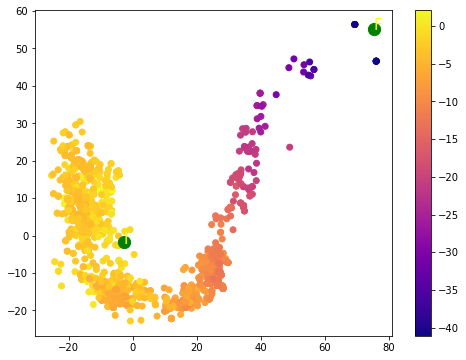

In [160]:
X = npyfile["pca_all_coords"][:,0]
Y = npyfile["pca_all_coords"][:,1]
Z = npyfile["pca_all_coords"][:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["SIM_G"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

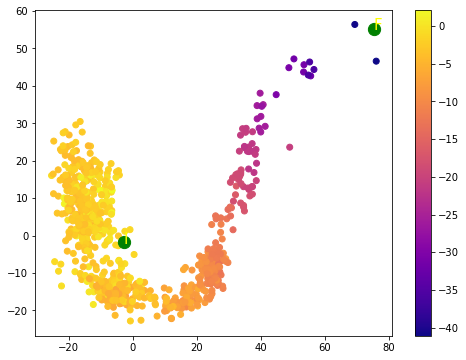

In [161]:
X = npyfile["pca_coords"][:,0]
Y = npyfile["pca_coords"][:,1]
Z = npyfile["pca_coords"][:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["SIM_G_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

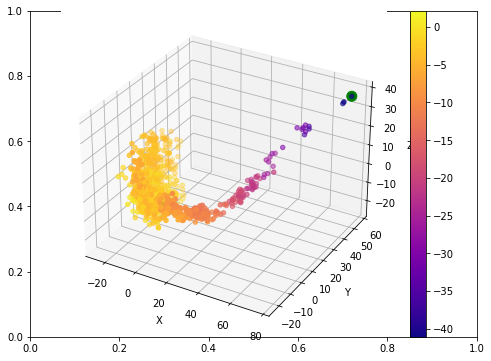

In [162]:
X = npyfile["pca_coords"][:,0]
Y = npyfile["pca_coords"][:,1]
Z = npyfile["pca_coords"][:,2]

# PCA: 3 components
fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(X,Y,Z,
          c=npyfile["SIM_G_uniq"],
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
z = [Z[0], Z[-1]]
ax.scatter(x,y,z,s=100,c="green",alpha=1)

#### Try use PCA directly without AE

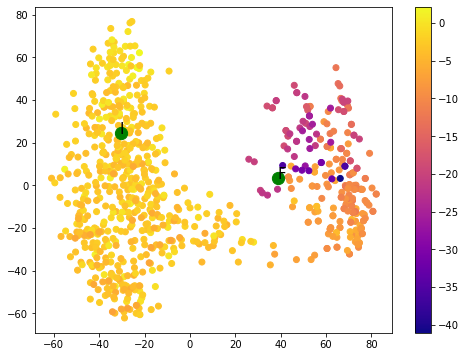

In [163]:
pca_coords1 = PCA(n_components=3).fit_transform(npyfile["SIM_scar_uniq"])
pca_coords1.shape

X = pca_coords1[:,0]
Y = pca_coords1[:,1]
Z = pca_coords1[:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["SIM_G_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="black")

### 2. PHATE Vis

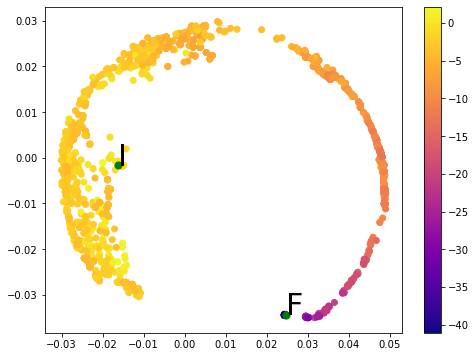

In [164]:
X_phate = npyfile["phate_all_coords"][:,0]
Y_phate = npyfile["phate_all_coords"][:,1]

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X_phate,Y_phate,
                c=npyfile["SIM_G"], 
                cmap='plasma',
               )

plt.colorbar(im)

annotations=["I","F"]
x = [X_phate[0],X_phate[-1]]
y = [Y_phate[0],Y_phate[-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=30,c="black")

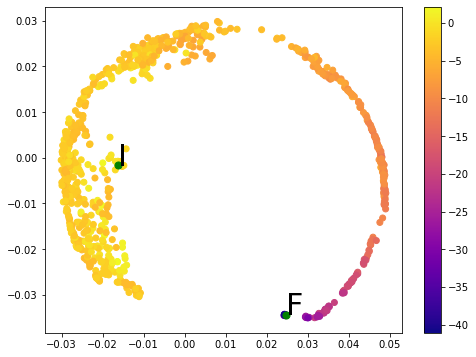

In [165]:
X_phate = npyfile["phate_coords"][:,0]
Y_phate = npyfile["phate_coords"][:,1]

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X_phate,Y_phate,
                c=npyfile["SIM_G_uniq"], 
                cmap='plasma',
               )

plt.colorbar(im)

annotations=["I","F"]
x = [X_phate[0],X_phate[-1]]
y = [Y_phate[0],Y_phate[-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=30,c="black")

#### PHATE without AE

Calculating PHATE...
  Running PHATE on 812 observations and 4000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.38 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.42 seconds.
  Calculating optimal t...


/Users/chenwei/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 66 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Automatically selected t = 24
  Calculated optimal t in 0.86 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.25 seconds.
Calculated PHATE in 1.62 seconds.


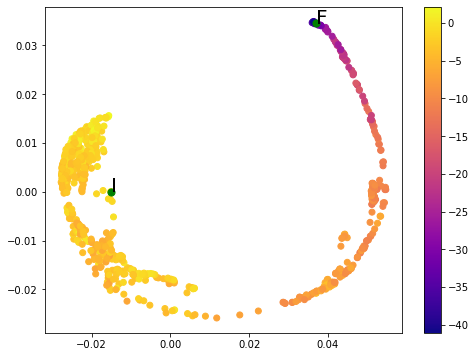

In [166]:
phate_operator = phate.PHATE(n_jobs=-2)
phate1 = phate_operator.fit_transform(npyfile["SIM_scar_uniq"])

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(phate1[:,0],
          phate1[:,1],
          c=npyfile["SIM_G_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [phate1[:,0][0],phate1[:,0][-1]]
y = [phate1[:,1][0],phate1[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")